In [1]:
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [3]:
import os
import sys
import time

import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
import tensorrt as trt
from PIL import Image

In [4]:
# This function is generalized for multiple inputs/outputs.
# inputs and outputs are expected to be lists of HostDeviceMem objects.
def do_inference(context, bindings, inputs, outputs, stream, batch_size=1):
    # Transfer input data to the GPU.
    [cuda.memcpy_htod_async(inp.device, inp.host, stream) for inp in inputs]
    # Run inference.
    context.execute_async(
        batch_size=batch_size, bindings=bindings, stream_handle=stream.handle
    )
    # Transfer predictions back from the GPU.
    [cuda.memcpy_dtoh_async(out.host, out.device, stream) for out in outputs]
    # Synchronize the stream
    stream.synchronize()
    # Return only the host outputs.
    return [out.host for out in outputs]

In [5]:
# Simple helper data class that's a little nicer to use than a 2-tuple.
class HostDeviceMem(object):
    def __init__(self, host_mem, device_mem):
        self.host = host_mem
        self.device = device_mem

    def __str__(self):
        return "Host:\n" + str(self.host) + "\nDevice:\n" + str(self.device)

    def __repr__(self):
        return self.__str__()

In [6]:
import numpy as np
import pycuda.driver as cuda
import tensorrt as trt


def allocate_buffers(
    engine,
    binding_to_type={"Input": np.float32, "NMS": np.float32, "NMS_1": np.int32},
    max_batch_size=-1,
):
    """Allocates host and device buffer for TRT engine inference.
    This function is similair to the one in common.py, but
    converts network outputs (which are np.float32) appropriately
    before writing them to Python buffer. This is needed, since
    TensorRT plugins doesn't support output type description, and
    in our particular case, we use NMS plugin as network output.
    Args:
        engine (trt.ICudaEngine): TensorRT engine
    Returns:
        inputs [HostDeviceMem]: engine input memory
        outputs [HostDeviceMem]: engine output memory
        bindings [int]: buffer to device bindings
        stream (cuda.Stream): cuda stream for engine inference synchronization
    """
    inputs = []
    outputs = []
    bindings = []
    stream = cuda.Stream()

    # Current NMS implementation in TRT only supports DataType.FLOAT but
    # it may change in the future, which could brake this sample here
    # when using lower precision [e.g. NMS output would not be np.float32
    # anymore, even though this is assumed in binding_to_type]

    for binding in engine:
        size = trt.volume(engine.get_binding_shape(binding)) * max_batch_size
        dtype = binding_to_type[str(binding)]
        # Allocate host and device buffers
        host_mem = cuda.pagelocked_empty(size, dtype)
        device_mem = cuda.mem_alloc(host_mem.nbytes)
        # Append the device buffer to device bindings.
        bindings.append(int(device_mem))
        # Append to the appropriate list.
        if engine.binding_is_input(binding):
            inputs.append(HostDeviceMem(host_mem, device_mem))
        else:
            outputs.append(HostDeviceMem(host_mem, device_mem))
    return inputs, outputs, bindings, stream

In [7]:
TRT_LOGGER = trt.Logger(trt.Logger.INFO)

In [8]:
def load_engine(trt_runtime, engine_path):
    assert os.path.exists(engine_path)
    with open(engine_path, "rb") as f:
        engine_data = f.read()
    return trt_runtime.deserialize_cuda_engine(engine_data)

In [9]:
class TRTInference(object):
    """Manages TensorRT objects for model inference."""

    def __init__(self, trt_engine_path, max_batch_size):
        """Initializes TensorRT objects needed for model inference.
        Args:
            trt_engine_path (str): path where TensorRT engine should be stored
        """
        self.max_batch_size = max_batch_size

        # We first load all custom plugins shipped with TensorRT,
        # some of them will be needed during inference
        trt.init_libnvinfer_plugins(TRT_LOGGER, "")

        # Initialize runtime needed for loading TensorRT engine from file
        self.trt_runtime = trt.Runtime(TRT_LOGGER)
        # TRT engine placeholder
        self.trt_engine = None

        # Display requested engine settings to stdout
        print("TensorRT inference engine settings:")

        # If we get here, the file with engine exists, so we can load it
        print("Loading cached TensorRT engine from {}".format(trt_engine_path))
        self.trt_engine = load_engine(self.trt_runtime, trt_engine_path)

        print(self.trt_engine.max_batch_size)

        self.binding_to_type = dict()
        for index in range(self.trt_engine.num_bindings):
            name = self.trt_engine.get_binding_name(index)
            dtype = trt.nptype(self.trt_engine.get_binding_dtype(index))
            shape = tuple(self.trt_engine.get_binding_shape(index))
            shape = list(map(lambda x: 1 if x == -1 else x, shape))
            # data = torch.from_numpy(np.empty(shape, dtype=np.dtype(dtype))).to(device)
            self.binding_to_type[name] = dtype

        # This allocates memory for network inputs/outputs on both CPU and GPU
        (self.inputs, self.outputs, self.bindings, self.stream,) = allocate_buffers(
            self.trt_engine,
            self.binding_to_type,
            self.max_batch_size,  # for dynamic shapes
        )

        # Execution context is needed for inference
        self.context = self.trt_engine.create_execution_context()

    def __call__(self, img, batch_size, image_size):
        # Copy it into appropriate place into memory
        # (self.inputs was returned earlier by allocate_buffers())
        np.copyto(self.inputs[0].host, img.ravel())

        # When infering on single image, we measure inference
        # time to output it to the user
        inference_start_time = time.time()

        if self.max_batch_size == -1:
            # Dynamic
            self.context.set_binding_shape(0, (batch_size, 3, image_size, image_size))

        # Fetch output from the model
        outputs = do_inference(
            self.context,
            bindings=self.bindings,
            inputs=self.inputs,
            outputs=self.outputs,
            stream=self.stream,
            batch_size=batch_size,
        )

        # Output inference time
        print(
            "TensorRT inference time: {} ms".format(
                int(round((time.time() - inference_start_time) * 1000))
            )
        )

        # And return results
        return outputs

In [10]:
import os

batch_size = 1
model = TRTInference("../weights/yolov7-tiny76-nms-trt.trt", -1)

TensorRT inference engine settings:
Loading cached TensorRT engine from ../weights/yolov7-tiny76-nms-trt.trt
1


In [11]:
import random
import time
from collections import OrderedDict, namedtuple
from pathlib import Path

import cv2
import numpy as np
import tensorrt as trt
import torch
from PIL import Image

/home/jovyan/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
device = torch.device("cuda:0")
img = cv2.imread("../inference/images/image2.jpg")
img.shape

(480, 640, 3)

In [13]:
import cv2
import matplotlib.pyplot as plt

BOX_COLOR = (255, 0, 0)  # Red
TEXT_COLOR = (255, 255, 255)  # White
LEFT_COLOR = (255, 0, 0)
CENTER_COLOR = (0, 255, 0)
RIGHT_COLOR = (0, 0, 255)


def clip(x, y, width, height, normalized=False):
    if normalized:
        x = x * width
        y = y * height
    x = max(x, 0)
    y = max(y, 0)
    x = min(x, width)
    y = min(y, height)
    x = int(round(x))
    y = int(round(y))
    return x, y


def visualize_bbox(
    img,
    bbox,
    landmark,
    landmark_mask,
    color=BOX_COLOR,
    thickness=2,
    radius=2,
    bbox_type="coco",
    landmark_normalized: bool = True,
):
    r"""Visualizes a single bounding box on the image
    Args:
        bbox: coco
    """

    if bbox_type == "coco":
        x_min, y_min, w, h = bbox
        x_min, x_max, y_min, y_max = (
            int(x_min),
            int(x_min + w),
            int(y_min),
            int(y_min + h),
        )
    elif bbox_type == "pascal_voc":
        x_min, y_min, x_max, y_max = bbox
    elif bbox_type == "albumentations":
        x_min, y_min, x_max, y_max = bbox
        x_min, y_min, x_max, y_max = (
            int(x_min * img.shape[1]),
            int(y_min * img.shape[0]),
            int(x_max * img.shape[1]),
            int(y_max * img.shape[0]),
        )
    elif bbox_type == "yolo":
        cx, cy, w, h = bbox
        x_min, y_min, x_max, y_max = cx - w / 2, cy - h / 2, cx + w / 2, cy + h / 2
        x_min, y_min, x_max, y_max = (
            int(x_min * img.shape[1]),
            int(y_min * img.shape[0]),
            int(x_max * img.shape[1]),
            int(y_max * img.shape[0]),
        )
    else:
        raise KeyError("bbox_type error")

    x_min, y_min, x_max, y_max = (
        int(round(x_min)),
        int(round(y_min)),
        int(round(x_max)),
        int(round(y_max)),
    )

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    if landmark is not None and landmark_mask is not None:
        if landmark_mask[0] > 0:
            img = cv2.circle(
                img,
                clip(
                    landmark[0],
                    landmark[1],
                    img.shape[1],
                    img.shape[0],
                    landmark_normalized,
                ),
                radius=radius,
                color=LEFT_COLOR,
                thickness=-1,
            )
        if landmark_mask[1] > 0:
            img = cv2.circle(
                img,
                clip(
                    landmark[2],
                    landmark[3],
                    img.shape[1],
                    img.shape[0],
                    landmark_normalized,
                ),
                radius=radius,
                color=RIGHT_COLOR,
                thickness=-1,
            )
        if landmark_mask[2] > 0:
            img = cv2.circle(
                img,
                clip(
                    landmark[4],
                    landmark[5],
                    img.shape[1],
                    img.shape[0],
                    landmark_normalized,
                ),
                radius=radius,
                color=CENTER_COLOR,
                thickness=-1,
            )
        if landmark_mask[3] > 0:
            img = cv2.circle(
                img,
                clip(
                    landmark[6],
                    landmark[7],
                    img.shape[1],
                    img.shape[0],
                    landmark_normalized,
                ),
                radius=radius,
                color=LEFT_COLOR,
                thickness=-1,
            )
        if landmark_mask[4] > 0:
            img = cv2.circle(
                img,
                clip(
                    landmark[8],
                    landmark[9],
                    img.shape[1],
                    img.shape[0],
                    landmark_normalized,
                ),
                radius=radius,
                color=RIGHT_COLOR,
                thickness=-1,
            )

    return img


def visualize(
    image,
    bboxes,
    landmarks,
    landmarks_mask,
    bbox_type="coco",
    thickness=2,
    radius=2,
    landmark_normalized: bool = True,
):
    img = image.copy()
    for bbox, landmark, landmark_mask in zip(bboxes, landmarks, landmarks_mask):
        img = visualize_bbox(
            img,
            bbox,
            landmark,
            landmark_mask,
            bbox_type=bbox_type,
            thickness=thickness,
            radius=radius,
            landmark_normalized=landmark_normalized,
        )
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(img)
    plt.show()

In [14]:
def letterbox(
    im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32
):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(
        im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color
    )  # add border
    return im, r, (dw, dh)

In [15]:
def postprocess(boxes, r, dwdh):
    dwdh = torch.tensor(dwdh * 2).to(boxes.device)
    boxes -= dwdh
    boxes /= r
    return boxes

In [16]:
names = ["face"]
colors = {
    name: [random.randint(0, 255) for _ in range(3)] for i, name in enumerate(names)
}

In [17]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)
im = image.astype(np.float32)
im.shape

(1, 3, 640, 640)

In [18]:
# im = torch.from_numpy(im).to(device)
im /= 255.0
im.shape

(1, 3, 640, 640)

In [19]:
result = model(im, batch_size, 640)
result[0]

TensorRT inference time: 40 ms


array([2], dtype=int32)

In [43]:
mask_resolution = 56

nums = result[0].reshape(-1, 1)[0]
boxes = result[1].reshape(-1, 100, 4)[0]
scores = result[2].reshape(-1, 100, 1)[0]
classes = result[3].reshape(-1, 100, 1)[0]
lmks = result[4].reshape(-1, 100, 10)[0]
lmks_mask = result[5].reshape(-1, 100, 5)[0]

nums.shape, boxes.shape, scores.shape, classes.shape, lmks.shape, lmks_mask.shape

((1,), (100, 4), (100, 1), (100, 1), (100, 10), (100, 5))

In [44]:
nums

array([2], dtype=int32)

In [45]:
boxes = boxes[: nums[0]]
scores = scores[: nums[0]]
classes = classes[: nums[0]]
lmks = lmks[: nums[0]]
lmks_mask = lmks_mask[: nums[0]] > 0.9

boxes.shape, scores.shape, classes.shape, lmks.shape, lmks_mask.shape

((2, 4), (2, 1), (2, 1), (2, 10), (2, 5))

In [46]:
image.shape

(1, 3, 640, 640)

In [47]:
nimg = image[0].copy().transpose(1, 2, 0)
nimg = nimg.astype(np.uint8)
# nimg = cv2.cvtColor(nimg, cv2.COLOR_BGR2RGB)

pnimg = nimg.copy()
pnimg.shape

(640, 640, 3)

In [48]:
lmks_mask.shape

(2, 5)

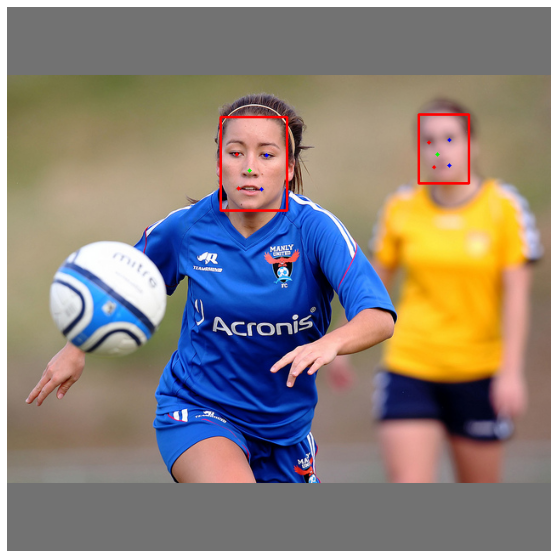

In [49]:
import numpy as np

visualize(
    pnimg,
    boxes,
    lmks,
    lmks_mask,
    bbox_type="pascal_voc",
    landmark_normalized=False,
)